In [ ]:
!pip install mycolorpy

In [ ]:
!apt-get install exiftool
!pip install git+https://github.com/detecttechnologies/thermal_base.git@main

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
libimage-exiftool-perl is already the newest version (10.80-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Cloning https://github.com/detecttechnologies/thermal_base.git (to revision main) to /tmp/pip-req-build-y8liblmm
  Running command git clone -q https://github.com/detecttechnologies/thermal_base.git /tmp/pip-req-build-y8liblmm


In [ ]:
!pip install rasterio

In [ ]:
# from lsat_imgread import import_image
# from dji_imgread import read_image
import matplotlib.pyplot as plt
import numpy as np
from mycolorpy import colorlist as mcp
import rasterio as rio
import numpy.ma as ma
import imutils
from thermal_base import ThermalImage

In [ ]:
def normalize_data(data):
    # normalizes the data
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [ ]:
def read_image(image_path):
    """This function transforms a DJI Mavic 2 Enterprise Due drone image into a numpy array.
    input: JPG thermal image path.
    output: temperature numpy array."""

    # Uses the library thermal_base to process the DJI image.
    # (https://github.com/detecttechnologies/thermal_base)

    image = ThermalImage(image_path=image_path, camera_manufacturer="dji")

    thermal_np = image.thermal_np           # The temperature matrix as a np array
    raw_sensor_np = image.raw_sensor_np     # The raw thermal sensor excitation values # as a np array
    meta = image.meta                     # Image metadata

    # return normalize_data(raw_sensor_np), meta
    return thermal_np, meta

In [ ]:
def rotate_image(img):
    # rotates image
    return imutils.rotate(img, angle=12.5)

In [ ]:
def import_image(image_path, band):
    with rio.open(image_path) as img:
        image = img.read(1)
        # image_array = np.array(image, dtype="float64")
        # rotating image
        image_array = rotate_image(image)

    # converting temperatures from Kelvin to Celcius
    if band == 10:
        L = 3.3420E-04 * image_array + 0.10000
        image_array = (1321.0789 / np.log((774.8853 / L) + 1)) - 273.15
    elif band == 11:
        image_array = (1201.1442 / np.log((480.8883 / (3.3420E-04 * image_array + 0.10000)) + 1))

    # image_array = normalize_data(image_array)

    return ma.masked_less_equal(image_array, 0)

In [53]:
def compare_images(landsat, drone):
    plt.figure(figsize=(16,8))
    plt.subplot(1, 2, 1)
    plt.xlabel("Temperature (˚C)")
    plt.ylabel("Number of of Pixels")
    plt.title("Landsat 8")
    plt.hist(landsat, color=mcp.gen_color(cmap="Blues", n=landsat.shape[1]))
    # plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.xlabel("Temperature (˚C)")
    plt.title("DJI Drone")
    plt.hist(drone, color=mcp.gen_color(cmap="Greens", n=drone.shape[1]))
    # plt.legend(loc='upper right')
    plt.show()

### Data collected on 12/14/2021

In [ ]:
# Reading both images
landsat_image = import_image("/content/drive/MyDrive/Grad/Research/Github-Colab/Cofc-Research/img/LC08_L1TP_016037_20211214_20211223_02_T1_B10.TIF", 10)
dji_image, dji_meta = read_image("/content/drive/MyDrive/Grad/Research/Github-Colab/Cofc-Research/img/DJI_0392.JPG")

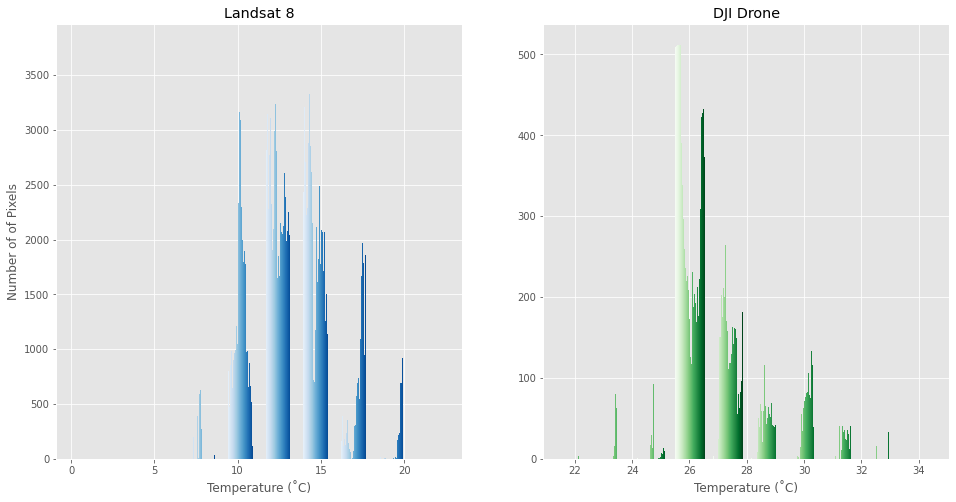

In [54]:
# Comparing images' histograms
compare_images(landsat_image, dji_image)

In [41]:
landsat_image.shape

(7771, 7641)

In [42]:
dji_image.shape

(512, 640)

In [43]:
# Trying to obtaing a correlation between the images
from scipy.stats.stats import pearsonr
import pandas as pd

In [47]:
# satellite_image = pd.DataFrame(landsat_image)

# def get_correlation(vals, row):
#   return pearsonr(vals, dji_image[row])
# for row_l in range(landsat_image.shape[1]):
#   for row in range(dji_image.shape[0]):
#     range = satellite_image[row_l].rolling(window=dji_image.shape[1]).to_numpy()
#     print(get_correlation(range, row))

### Data collected on 03/04/2022

In [49]:
# Reading both images
landsat_image_2 = import_image("/content/drive/MyDrive/Grad/Research/Github-Colab/Cofc-Research/img/LC08_L1TP_016037_20220304_20220305_02_RT_B10.TIF", 10)
dji_image_2, dji_meta_2 = read_image("/content/drive/MyDrive/Grad/Research/Github-Colab/Cofc-Research/img/DJI_0518.JPG")

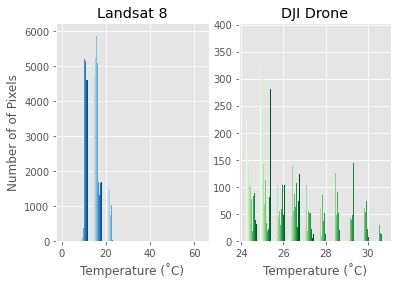

In [50]:
# Comparing images' histograms
compare_images(landsat_image_2, dji_image_2)